In [96]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')
# %matplotlib inline

from scipy.stats import shapiro, mannwhitneyu, norm, levene

from tqdm.auto import tqdm


In [2]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [3]:
control = pd.read_csv('control_group.csv', sep=';')
test = pd.read_csv('test_group.csv', sep=';')

In [4]:
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


    Campaign Name: Тип целевой кампании для целевой страницы объявления.
    
    Date: дата

    Spend [USD]: сумма денег, потраченная на рекламу в кампании.

    of Impressions: количество людей, просмотревших рекламу в кампании (содержит повторные просмотры рекламы одним и тем же человеком).

    Reach: количество уникальных людей, увидевших рекламу в рамках кампании.

    of Website Clicks: количество пользователей, перешедших по ссылке веб-сайта в рекламе кампании.

    of Searches: количество пользователей, которые выполнили поиск на веб-сайте.

    of View Content: количество пользователей, просмотревших сведения о продукте.

    of Add to Cart: количество пользователей, которые добавили товар в корзину.

    of Purchase: количество пользователей, которые приобрели продукт.

In [6]:
control.isnull().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

In [7]:
test.isnull().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64

In [8]:
control.dropna(inplace= True)

In [9]:
df = control.merge(test, how='outer').reset_index(drop= True)

In [10]:
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Test Campaign,1.08.2019,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0
2,Test Campaign,10.08.2019,2790,95054.0,79632.0,8125.0,2312.0,1804.0,424.0,275.0
3,Control Campaign,10.08.2019,2149,117624.0,91257.0,2277.0,2475.0,1984.0,1629.0,734.0
4,Test Campaign,11.08.2019,2420,83633.0,71286.0,3750.0,2893.0,2617.0,1075.0,668.0


In [11]:
def to_clean(val):
    return val.strip().lower().replace("# ", "").replace("of ", "").replace(" ","_").replace("[usd]", "usd")

In [12]:
df.rename(columns=to_clean, inplace= True)

In [13]:
df.dtypes

campaign_name      object
date               object
spend_usd           int64
impressions       float64
reach             float64
website_clicks    float64
searches          float64
view_content      float64
add_to_cart       float64
purchase          float64
dtype: object

In [14]:
df['date']= pd.to_datetime(df['date'],format='%d.%m.%Y')

In [15]:
df = df.sort_values('date')

In [16]:
df.head()

,campaign_name,date,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchase
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Test Campaign,2019-08-01,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0
23,Test Campaign,2019-08-02,2542,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0
22,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
45,Test Campaign,2019-08-03,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0


In [17]:
df.campaign_name.value_counts()

Test Campaign       30
Control Campaign    29
Name: campaign_name, dtype: int64

In [18]:
df.groupby('campaign_name', as_index=False) \
    .agg({'spend_usd':'sum', 'impressions':'sum', 
          'reach':'sum', 'website_clicks':'sum', 
          'searches':'sum', 'view_content':'sum', 
          'add_to_cart':'sum', 'purchase':'sum'})

,campaign_name,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchase
0,Control Campaign,66818,3177233.0,2576503.0,154303.0,64418.0,56370.0,37700.0,15161.0
1,Test Campaign,76892,2237544.0,1604747.0,180970.0,72569.0,55740.0,26446.0,15637.0


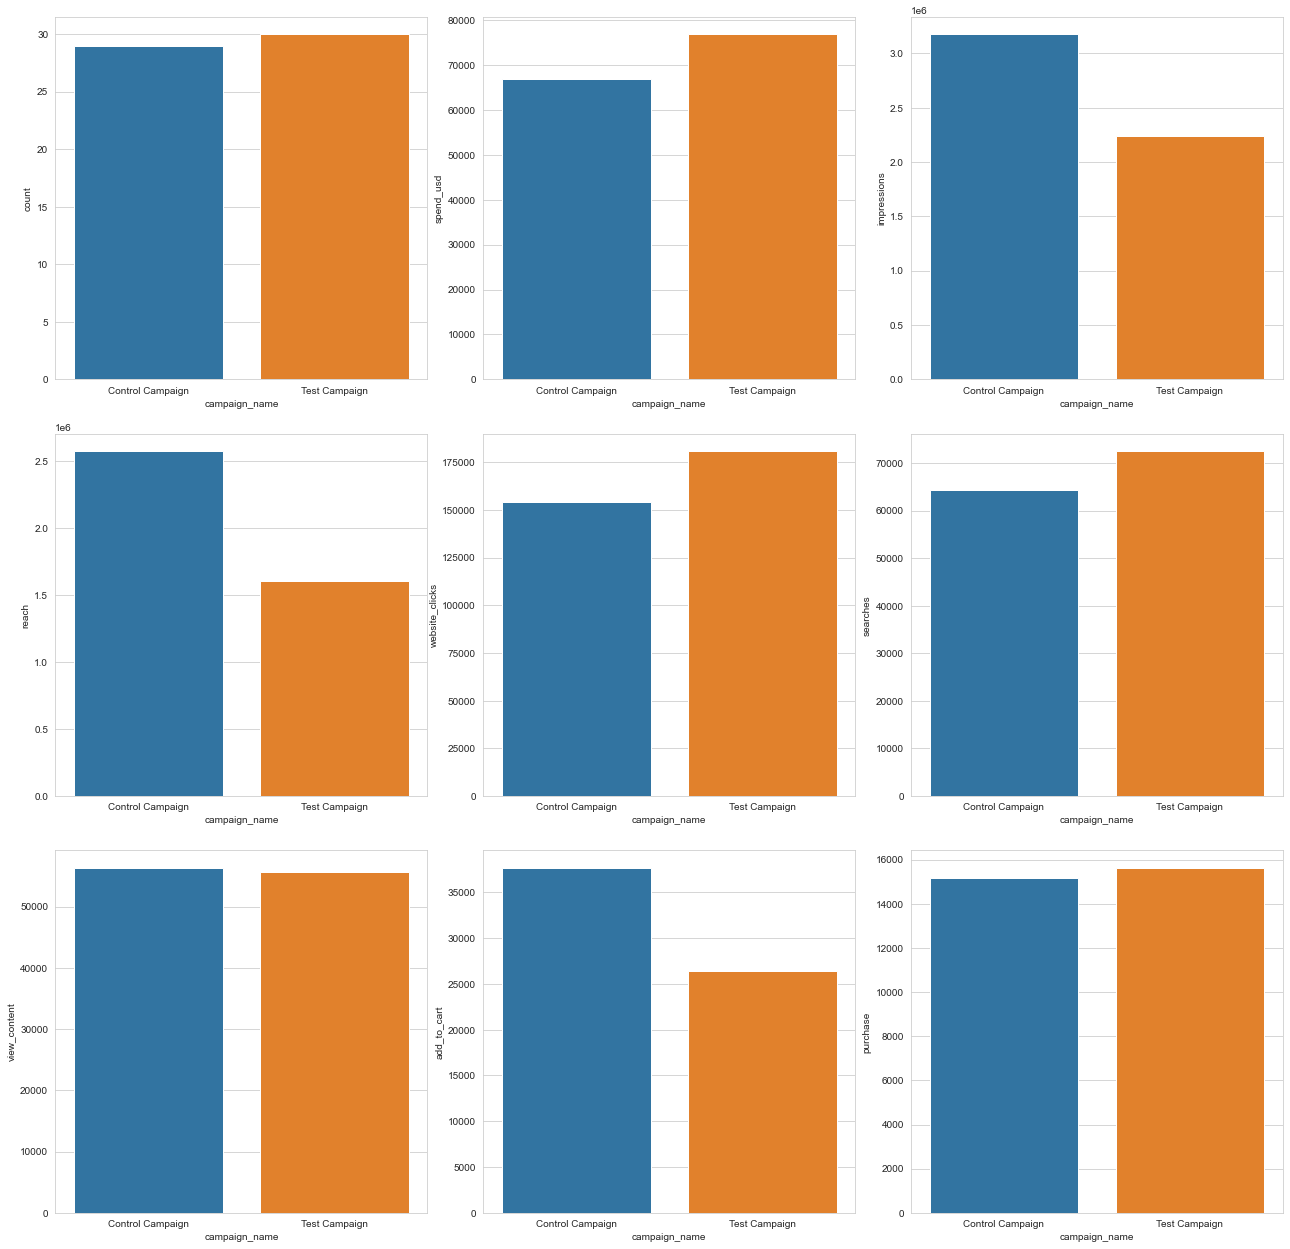

In [19]:
fig, ax = plt.subplots(3,3, figsize=(22,22),sharex=False)

sns.barplot(x='campaign_name', y='purchase', data=df,ci=None, estimator=sum, ax=ax[2,2])
sns.barplot(x='campaign_name', y='add_to_cart', data=df,ci=None, estimator=sum, ax=ax[2,1])
sns.barplot(x='campaign_name', y='view_content', data=df,ci=None, estimator=sum, ax=ax[2,0])
sns.barplot(x='campaign_name', y='searches', data=df,ci=None, estimator=sum, ax=ax[1,2])
sns.barplot(x='campaign_name', y='website_clicks', data=df,ci=None, estimator=sum, ax=ax[1,1])
sns.barplot(x='campaign_name', y='reach', data=df,ci=None, estimator=sum, ax=ax[1,0])
sns.barplot(x='campaign_name', y='impressions', data=df,ci=None, estimator=sum, ax=ax[0,2])
sns.barplot(x='campaign_name', y='spend_usd', data=df,ci=None, estimator=sum, ax=ax[0,1])
sns.countplot(data = df , x = 'campaign_name', ax=ax[0,0])



plt.subplots_adjust(hspace = 0.15, wspace=0.15);

In [20]:
df.head()

,campaign_name,date,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchase
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Test Campaign,2019-08-01,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0
23,Test Campaign,2019-08-02,2542,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0
22,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
45,Test Campaign,2019-08-03,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0


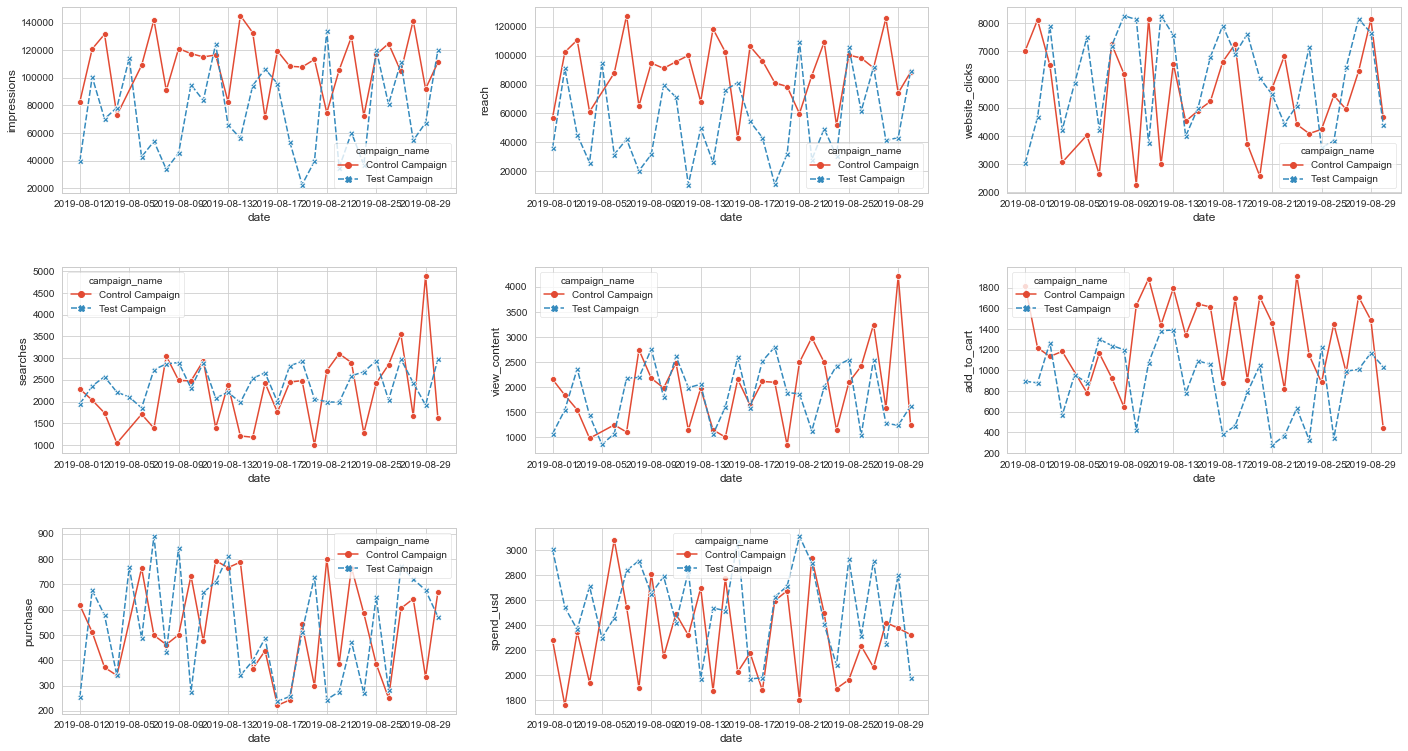

In [113]:
fig, ax = plt.subplots(3,3, figsize=(24,13),sharex=False)

sns.lineplot(data=df,x="date",y="impressions",hue="campaign_name",style="campaign_name",markers=True,dashes=True, ax=ax[0,0])
sns.lineplot(data=df,x="date",y="reach",hue="campaign_name",style="campaign_name",markers=True,dashes=True, ax=ax[0,1])
sns.lineplot(data=df,x="date",y="website_clicks",hue="campaign_name",style="campaign_name",markers=True,dashes=True, ax=ax[0,2])
sns.lineplot(data=df,x="date",y="searches",hue="campaign_name",style="campaign_name",markers=True,dashes=True, ax=ax[1,0])
sns.lineplot(data=df,x="date",y="view_content",hue="campaign_name",style="campaign_name",markers=True,dashes=True, ax=ax[1,1])
sns.lineplot(data=df,x="date",y="add_to_cart",hue="campaign_name",style="campaign_name",markers=True,dashes=True, ax=ax[1,2])
sns.lineplot(data=df,x="date",y="purchase",hue="campaign_name",style="campaign_name",markers=True,dashes=True, ax=ax[2,0])
sns.lineplot(data=df,x="date",y="spend_usd",hue="campaign_name",style="campaign_name",markers=True,dashes=True, ax=ax[2,1])

ax[2,2].set_yticks([])
ax[2,2].set_xticks([])
sns.despine(bottom=True, top=True, left=True, right=True, trim=True, ax=ax[2,2])

plt.subplots_adjust(hspace = 0.4, wspace=0.2);

In [23]:
df.head()

,campaign_name,date,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchase
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Test Campaign,2019-08-01,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0
23,Test Campaign,2019-08-02,2542,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0
22,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
45,Test Campaign,2019-08-03,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0


In [24]:
df['ctr'] = df['website_clicks'] / df['impressions'] * 100
df['ctr'] = round(df['ctr'],2)

In [132]:
df['ctr1'] = df['website_clicks'] / df['reach'] * 100
df['ctr1'] = round(df['ctr1'],2)

In [118]:
df['conv_to_purchase'] = df['purchase'] / df['website_clicks'] * 100
df['conv_to_purchase'] = round(df['conv_to_purchase'],2)

In [119]:
df.head()

,campaign_name,date,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchase,ctr,conv_to_purchase
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,8.48,8.81
1,Test Campaign,2019-08-01,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0,7.68,8.39
23,Test Campaign,2019-08-02,2542,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0,4.62,14.54
22,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,6.70,6.30
45,Test Campaign,2019-08-03,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0,11.22,7.33


In [26]:
df.groupby('campaign_name', as_index=False) \
    .agg({'ctr':'mean'})

,campaign_name,ctr
0,Control Campaign,5.095517
1,Test Campaign,10.241667


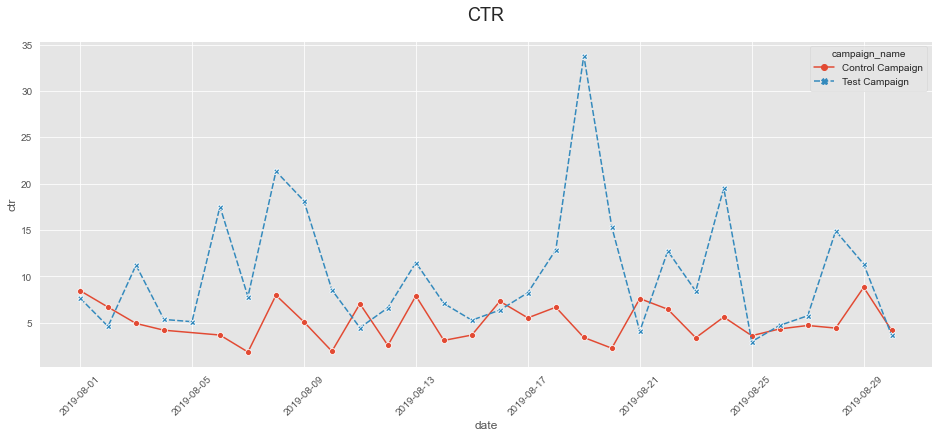

In [95]:
plt.figure(figsize=(16,6))
ax=sns.lineplot(data=df,x="date",y="ctr",hue="campaign_name",style="campaign_name",markers=True,dashes=True)
ax.yaxis.grid(True)
plt.xticks(rotation=45)
ax.set_title("CTR", fontsize=18, pad=20);

In [28]:
df.head()

,campaign_name,date,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchase,ctr
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,8.48
1,Test Campaign,2019-08-01,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0,7.68
23,Test Campaign,2019-08-02,2542,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0,4.62
22,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,6.70
45,Test Campaign,2019-08-03,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0,11.22


In [45]:
funnel = df.groupby('campaign_name',as_index=False) \
    .agg({'website_clicks':'sum','searches':'sum','view_content':'sum','add_to_cart':'sum','purchase':'sum'})

In [54]:
funnel['click_to_search'] = round(funnel['searches'] / funnel['website_clicks'] * 100,1)
funnel['search_to_view'] = round(funnel['view_content'] / funnel['searches'] * 100,1)
funnel['view_to_addcart'] = round(funnel['add_to_cart'] / funnel['view_content'] * 100,1)
funnel['addcart_to_purchase'] = round(funnel['purchase'] / funnel['add_to_cart'] * 100,1)

In [55]:
funnel

,campaign_name,website_clicks,searches,view_content,add_to_cart,purchase,click_to_search,search_to_view,view_to_addcart,addcart_to_purchase
0,Control Campaign,154303.0,64418.0,56370.0,37700.0,15161.0,41.7,87.5,66.9,40.2
1,Test Campaign,180970.0,72569.0,55740.0,26446.0,15637.0,40.1,76.8,47.4,59.1


In [75]:
funnel1 = funnel[['campaign_name','website_clicks','searches','view_content','add_to_cart','purchase']]

In [77]:
funnel1['ret_searches'] = round(funnel1['searches'] / funnel1['website_clicks'] *100,1)
funnel1['ret_view'] = round(funnel1['view_content'] / funnel1['website_clicks'] *100,1)
funnel1['ret_add_to_cart'] = round(funnel1['add_to_cart'] / funnel1['website_clicks'] *100,1)
funnel1['ret_purchase'] = round(funnel1['purchase'] / funnel1['website_clicks'] *100,1)

C:\Users\aliso\AppData\Local\Temp\ipykernel_8512\3979756230.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aliso\AppData\Local\Temp\ipykernel_8512\3979756230.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aliso\AppData\Local\Temp\ipykernel_8512\3979756230.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [78]:
funnel1

,campaign_name,website_clicks,searches,view_content,add_to_cart,purchase,ret_searches,ret_view,ret_add_to_cart,ret_purchase
0,Control Campaign,154303.0,64418.0,56370.0,37700.0,15161.0,41.7,36.5,24.4,9.8
1,Test Campaign,180970.0,72569.0,55740.0,26446.0,15637.0,40.1,30.8,14.6,8.6


In [92]:
stages = ["website_clicks", "searches", "view_content", "add_to_cart", "purchase"]
df_1 = pd.DataFrame(dict(number=[154303.0, 64418.0, 56370.0, 37700.0, 15161.0], stage=stages))
df_1['campaign_name'] = 'Control Campaign'
df_2 = pd.DataFrame(dict(number=[180970.0, 72569.0, 55740.0, 26446.0, 15637.0], stage=stages))
df_2['campaign_name'] = 'Test Campaign'
df_pic = pd.concat([df_1, df_2], axis=0)
fig = px.funnel(df_pic, x='number', y='stage', color='campaign_name')
fig.update_layout(
    title={
        'text': "Count for each stage",
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [97]:
stages = ["website_clicks", "searches", "view_content", "add_to_cart", "purchase"]
df_ret = pd.DataFrame(dict(number=[100.0, 41.7, 36.5, 24.4, 9.8], stage=stages))
df_ret['campaign_name'] = 'Control Campaign'
df_ret1 = pd.DataFrame(dict(number=[100.0, 40.1, 30.8, 14.6, 8.6], stage=stages))
df_ret1['campaign_name'] = 'Test Campaign'
df_pic1 = pd.concat([df_ret, df_ret1], axis=0)
fig = px.funnel(df_pic1, x='number', y='stage', color='campaign_name')
fig.update_layout(
    title={
        'text': "Conversion (%)",
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [91]:
stages = ["website_clicks", "searches", "view_content", "add_to_cart", "purchase"]
df_1 = pd.DataFrame(dict(number=[100.0, 41.7, 87.5, 66.9, 40.2], stage=stages))
df_1['campaign_name'] = 'Control Campaign'
df_2 = pd.DataFrame(dict(number=[100.0, 40.1, 76.8, 47.4, 59.1], stage=stages))
df_2['campaign_name'] = 'Test Campaign'
df_pic = pd.concat([df_1, df_2], axis=0)
fig = px.funnel(df_pic, x='number', y='stage', color='campaign_name')
fig.update_layout(
    title={
        'text': "Conversion (%) from the previous stage",
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

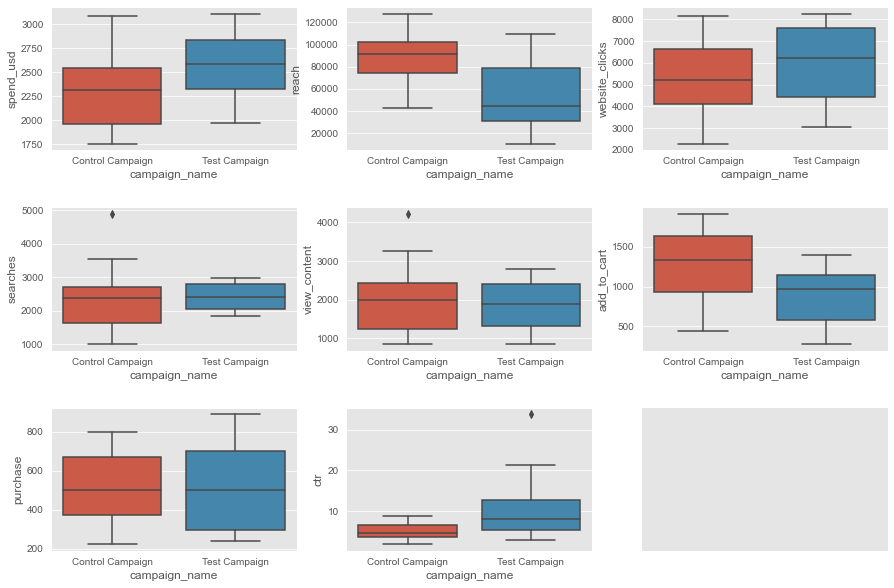

In [58]:
fig, ax = plt.subplots(3,3, figsize=(15,10),sharex=False)
sns.boxplot(y="spend_usd", data=df, x='campaign_name', ax=ax[0,0])
sns.boxplot(y="reach", data=df, x='campaign_name', ax=ax[0,1])
sns.boxplot(y="website_clicks", data=df, x='campaign_name', ax=ax[0,2])
sns.boxplot(y="searches", data=df, x='campaign_name', ax=ax[1,0])
sns.boxplot(y="view_content", data=df, x='campaign_name', ax=ax[1,1])
sns.boxplot(y="add_to_cart", data=df, x='campaign_name', ax=ax[1,2])
sns.boxplot(y="purchase", data=df, x='campaign_name', ax=ax[2,0])
sns.boxplot(y="ctr", data=df, x='campaign_name', ax=ax[2,1])
plt.subplots_adjust(hspace = 0.4, wspace=0.2);
ax[2,2].set_yticks([])
ax[2,2].set_xticks([])
sns.despine(bottom=True, top=True, left=True, right=True, trim=True, ax=ax[2,2])

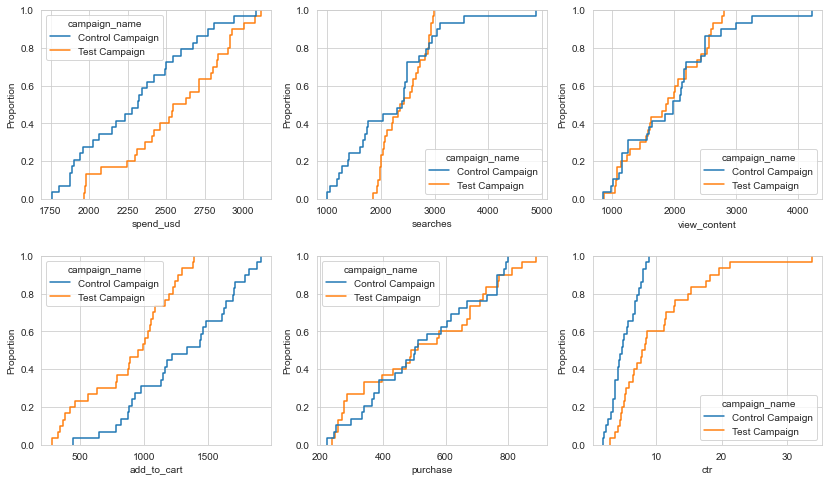

In [32]:
fig, ax = plt.subplots(2,3, figsize=(14,8),sharex=False)
sns.ecdfplot(data=df, x="spend_usd", hue= "campaign_name", ax=ax[0,0])
sns.ecdfplot(data=df, x="searches", hue= "campaign_name", ax=ax[0,1])
sns.ecdfplot(data=df, x="view_content", hue= "campaign_name", ax=ax[0,2])
sns.ecdfplot(data=df, x="add_to_cart", hue= "campaign_name", ax=ax[1,0])
sns.ecdfplot(data=df, x="purchase", hue= "campaign_name", ax=ax[1,1])
sns.ecdfplot(data=df, x="ctr", hue= "campaign_name", ax=ax[1,2])
plt.subplots_adjust(hspace = 0.3, wspace=0.2);

In [33]:
df.head()

,campaign_name,date,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchase,ctr
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,8.48
1,Test Campaign,2019-08-01,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0,7.68
23,Test Campaign,2019-08-02,2542,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0,4.62
22,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,6.70
45,Test Campaign,2019-08-03,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0,11.22


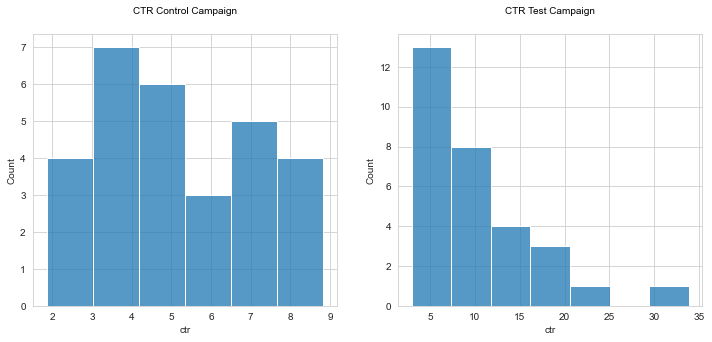

In [34]:
fig, ax = plt.subplots(1,2, figsize=(12,5),sharex=False)
sns.histplot(df.query("campaign_name == 'Control Campaign'").ctr, ax=ax[0])
sns.histplot(df.query("campaign_name == 'Test Campaign'").ctr, ax=ax[1])
ax[0].set_title("CTR Control Campaign", fontsize=10, color="k", pad=20)
ax[1].set_title("CTR Test Campaign", fontsize=10, color="k", pad=20)
plt.subplots_adjust(hspace = 0.7, wspace=0.2);

In [35]:
print(shapiro(df.query("campaign_name == 'Control Campaign'").ctr), shapiro(df.query("campaign_name == 'Test Campaign'").ctr), sep="\n")

ShapiroResult(statistic=0.954863429069519, pvalue=0.24425406754016876)
ShapiroResult(statistic=0.840957522392273, pvalue=0.0004032743745483458)


    H0 - нормальное распределение
    H1 - распределение не нормальное
    CTR контрольной рекламной кампании распределено по нормальному закону, тк pvalue > 0.05
        Принимается H0
    Распределение CTR тестовой рекламной кампании не нормально, тк pvalue < 0.05
        Принимается H1

In [36]:
mannwhitneyu(df.query("campaign_name == 'Control Campaign'").ctr, df.query("campaign_name == 'Test Campaign'").ctr)

MannwhitneyuResult(statistic=193.0, pvalue=0.00025057938355665065)

    pvalue < 0.05, принимается H1
    Распределение рангов CTR в тестовой и контрольной рекламной кампании статистически отличаются

In [133]:
df.groupby('campaign_name', as_index=False) \
    .agg({'ctr':[("median",'median'),("average",'mean')], 'ctr1':[("median",'median'),("average",'mean')]})

campaign_name    ctr              ctr1           
                    median    average median    average
0  Control Campaign  4.720   5.095517   5.52   6.449310
1     Test Campaign  8.035  10.241667  14.91  17.407333

  0%|          | 0/300 [00:00<?, ?it/s]

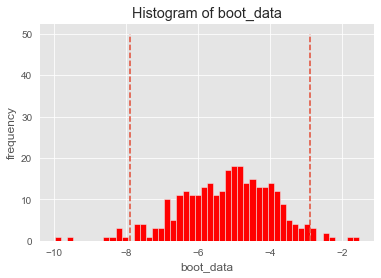

{'boot_data': [-6.584666666666666,
  -4.261666666666667,
  -5.189666666666667,
  -5.039333333333333,
  -3.8136666666666668,
  -4.507000000000001,
  -4.803666666666667,
  -6.291666666666666,
  -3.887333333333333,
  -5.434000000000001,
  -4.258666666666667,
  -4.901333333333333,
  -4.917333333333334,
  -3.5320000000000005,
  -5.769666666666668,
  -5.175666666666666,
  -3.5253333333333337,
  -4.3853333333333335,
  -3.9373333333333336,
  -5.5840000000000005,
  -5.262333333333333,
  -4.114666666666667,
  -4.512666666666665,
  -5.009666666666666,
  -5.601333333333333,
  -4.810999999999999,
  -4.981666666666667,
  -4.996,
  -4.406000000000001,
  -3.2216666666666667,
  -3.9159999999999995,
  -2.7309999999999994,
  -5.841333333333335,
  -4.549000000000001,
  -5.986333333333333,
  -5.372000000000001,
  -3.498,
  -5.010333333333333,
  -6.056666666666664,
  -3.644,
  -6.411666666666666,
  -3.098666666666666,
  -6.217666666666668,
  -3.939333333333333,
  -5.072666666666666,
  -6.801333333333334,
  

In [63]:
get_bootstrap(
    df.query("campaign_name == 'Control Campaign'").ctr, # числовые значения первой выборки
    df.query("campaign_name == 'Test Campaign'").ctr, # числовые значения второй выборки
    boot_it = 300, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

    pvalue < 0.05, принимается H1
    Средние величины CTR в тестовой и контрольной рекламной кампании статистически отличаются

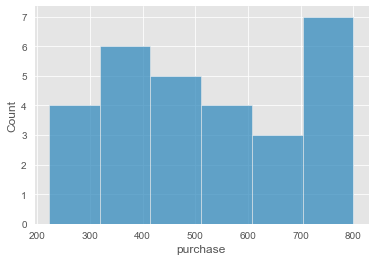

In [38]:
sns.histplot(df.query("campaign_name == 'Control Campaign'").purchase)
sns.despine()

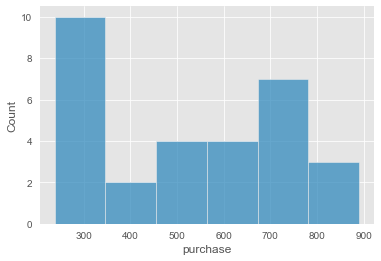

In [39]:
sns.histplot(df.query("campaign_name == 'Test Campaign'").purchase)
sns.despine()

In [40]:
print(shapiro(df.query("campaign_name == 'Control Campaign'").purchase), 
      shapiro(df.query("campaign_name == 'Test Campaign'").purchase), sep="\n")

ShapiroResult(statistic=0.9381417036056519, pvalue=0.08964285254478455)
ShapiroResult(statistic=0.9181894659996033, pvalue=0.024077769368886948)


In [41]:
mannwhitneyu(df.query("campaign_name == 'Control Campaign'").purchase, 
             df.query("campaign_name == 'Test Campaign'").purchase)

MannwhitneyuResult(statistic=439.0, pvalue=0.957674926453464)

    pvalue > 0.05, принимается H0
    Распределение рангов продаж в тестовой и контрольной рекламной кампании статистически не отличаются

  0%|          | 0/300 [00:00<?, ?it/s]

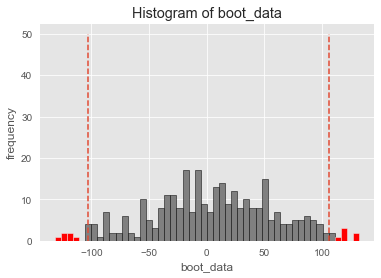

{'boot_data': [-57.5,
  8.0,
  40.5,
  59.56666666666667,
  -35.36666666666667,
  76.53333333333333,
  48.733333333333334,
  90.63333333333334,
  -88.46666666666667,
  16.066666666666666,
  -22.933333333333334,
  -27.333333333333332,
  -47.4,
  -131.86666666666667,
  2.6333333333333333,
  1.9,
  -29.666666666666668,
  -31.566666666666666,
  36.1,
  42.833333333333336,
  -7.866666666666666,
  -16.566666666666666,
  -4.133333333333334,
  23.766666666666666,
  52.233333333333334,
  -52.96666666666667,
  -9.3,
  -7.866666666666666,
  -101.26666666666667,
  -52.733333333333334,
  -20.933333333333334,
  -17.033333333333335,
  13.233333333333333,
  100.93333333333334,
  -16.3,
  17.1,
  4.4,
  -40.8,
  -24.633333333333333,
  46.03333333333333,
  117.66666666666667,
  95.26666666666667,
  18.833333333333332,
  -83.2,
  49.56666666666667,
  -56.63333333333333,
  130.66666666666666,
  63.9,
  -13.6,
  2.1,
  41.266666666666666,
  -23.9,
  22.833333333333332,
  11.133333333333333,
  -34.5,
  -10.

In [64]:
get_bootstrap(
    df.query("campaign_name == 'Control Campaign'").purchase, # числовые значения первой выборки
    df.query("campaign_name == 'Test Campaign'").purchase, # числовые значения второй выборки
    boot_it = 300, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

    pvalue > 0.05, принимается H0
    Средние величины продаж в тестовой и контрольной рекламной кампании статистически не отличаются

  0%|          | 0/300 [00:00<?, ?it/s]

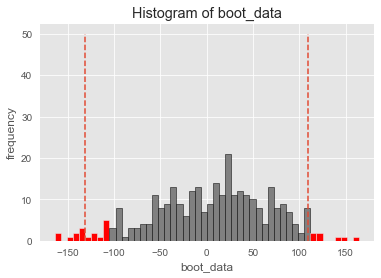

{'boot_data': [52.5,
  88.5,
  -135.0,
  14.5,
  -72.5,
  122.0,
  40.0,
  -45.5,
  68.0,
  72.0,
  7.5,
  5.5,
  -16.5,
  -131.0,
  46.5,
  107.5,
  -58.5,
  -48.0,
  31.0,
  76.5,
  31.0,
  23.5,
  50.5,
  109.5,
  80.0,
  2.5,
  30.5,
  110.0,
  51.0,
  -16.0,
  -96.0,
  -83.5,
  97.0,
  21.5,
  -56.0,
  42.0,
  -9.0,
  -1.0,
  26.5,
  -41.5,
  -28.5,
  106.5,
  91.0,
  85.0,
  11.5,
  56.5,
  19.0,
  59.0,
  -7.0,
  67.0,
  10.0,
  -10.0,
  -53.5,
  31.5,
  -97.0,
  -92.5,
  25.5,
  -14.5,
  24.5,
  -24.5,
  66.0,
  48.5,
  75.0,
  -102.0,
  35.5,
  25.5,
  -93.5,
  5.5,
  -94.0,
  -58.5,
  -35.0,
  -92.5,
  71.5,
  -134.5,
  22.0,
  -36.0,
  -102.0,
  -46.0,
  109.0,
  116.5,
  11.0,
  -19.5,
  -132.0,
  106.0,
  48.5,
  14.5,
  57.5,
  -54.5,
  61.0,
  89.5,
  4.5,
  -5.0,
  -103.0,
  122.0,
  -48.0,
  84.0,
  10.0,
  -18.0,
  -138.5,
  -33.0,
  -7.5,
  -21.5,
  14.5,
  42.5,
  -26.0,
  22.0,
  69.0,
  14.5,
  -119.0,
  10.0,
  45.5,
  -9.5,
  -25.5,
  25.0,
  -30.5,
  -40.0,
  3

In [65]:
get_bootstrap(
    df.query("campaign_name == 'Control Campaign'").purchase, # числовые значения первой выборки
    df.query("campaign_name == 'Test Campaign'").purchase, # числовые значения второй выборки
    boot_it = 300, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

    pvalue > 0.05, принимается H0
    Медианные величины продаж в тестовой и контрольной рекламной кампании статистически не отличаются

  0%|          | 0/300 [00:00<?, ?it/s]

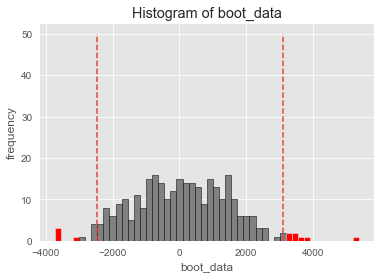

{'boot_data': [-1639.0,
  1596.0,
  843.0,
  -1474.0,
  2190.0,
  -546.0,
  -984.0,
  61.0,
  -2043.0,
  -1103.0,
  1318.0,
  35.0,
  1752.0,
  -3648.0,
  790.0,
  -1059.0,
  2403.0,
  1540.0,
  -3622.0,
  -944.0,
  -240.0,
  273.0,
  1799.0,
  1662.0,
  -552.0,
  1533.0,
  832.0,
  925.0,
  876.0,
  -1551.0,
  -273.0,
  1818.0,
  1567.0,
  591.0,
  -542.0,
  1207.0,
  -1662.0,
  -1069.0,
  22.0,
  1093.0,
  -1223.0,
  -375.0,
  -1477.0,
  -398.0,
  1885.0,
  -1805.0,
  869.0,
  -899.0,
  2341.0,
  -383.0,
  998.0,
  -2238.0,
  661.0,
  1556.0,
  -550.0,
  370.0,
  732.0,
  -94.0,
  958.0,
  -1280.0,
  1290.0,
  1882.0,
  501.0,
  -1704.0,
  972.0,
  -854.0,
  -651.0,
  -1740.0,
  -776.0,
  2561.0,
  -132.0,
  417.0,
  -2150.0,
  820.0,
  80.0,
  847.0,
  -1640.0,
  -1263.0,
  -1370.0,
  534.0,
  -841.0,
  -255.0,
  294.0,
  -1872.0,
  -125.0,
  -1065.0,
  -751.0,
  523.0,
  1235.0,
  374.0,
  1513.0,
  1083.0,
  -1229.0,
  414.0,
  -138.0,
  3615.0,
  1188.0,
  1144.0,
  1472.0,
  -88

In [66]:
get_bootstrap(
    df.query("campaign_name == 'Control Campaign'").purchase, # числовые значения первой выборки
    df.query("campaign_name == 'Test Campaign'").purchase, # числовые значения второй выборки
    boot_it = 300, # количество бутстрэп-подвыборок
    statistic = np.sum, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

    pvalue > 0.05, принимается H0
    Суммированные величины продаж в тестовой и контрольной рекламной кампании статистически не отличаются

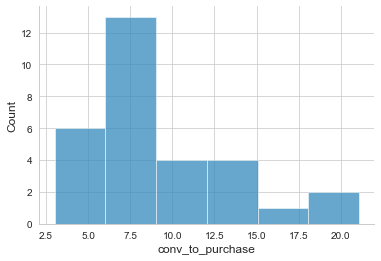

In [120]:
sns.histplot(df.query("campaign_name == 'Test Campaign'").conv_to_purchase)
sns.despine()

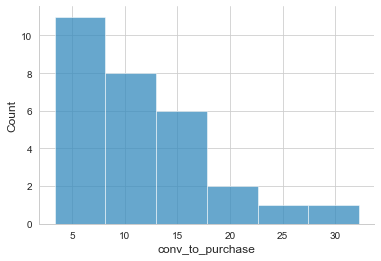

In [121]:
sns.histplot(df.query("campaign_name == 'Control Campaign'").conv_to_purchase)
sns.despine()

In [122]:
print(shapiro(df.query("campaign_name == 'Control Campaign'").conv_to_purchase), 
      shapiro(df.query("campaign_name == 'Test Campaign'").conv_to_purchase), sep="\n")

ShapiroResult(statistic=0.894529402256012, pvalue=0.007263942155987024)
ShapiroResult(statistic=0.9254655838012695, pvalue=0.037260912358760834)


In [123]:
mannwhitneyu(df.query("campaign_name == 'Control Campaign'").conv_to_purchase, 
             df.query("campaign_name == 'Test Campaign'").conv_to_purchase)

MannwhitneyuResult(statistic=503.5, pvalue=0.3025133706634894)

In [128]:
df.groupby('campaign_name', as_index=False) \
    .agg({'conv_to_purchase':[("median",'median'),("average",'mean')]})

campaign_name conv_to_purchase           
                              median    average
0  Control Campaign            10.23  11.477586
1     Test Campaign             8.45   9.230667

  0%|          | 0/300 [00:00<?, ?it/s]

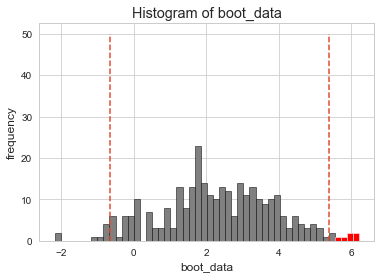

{'boot_data': [1.6083333333333332,
  1.2363333333333333,
  2.5506666666666664,
  1.387,
  1.9033333333333329,
  2.014333333333334,
  3.685333333333333,
  4.744000000000001,
  3.8033333333333337,
  1.2773333333333332,
  -0.8163333333333329,
  3.2850000000000006,
  1.241666666666667,
  4.111666666666666,
  -0.7543333333333331,
  2.4503333333333335,
  2.8790000000000004,
  1.7333333333333332,
  4.003333333333334,
  0.3606666666666669,
  1.566,
  2.5850000000000004,
  1.953666666666667,
  0.04233333333333311,
  2.076666666666667,
  1.2943333333333338,
  1.5603333333333338,
  2.5516666666666676,
  0.07999999999999984,
  5.078,
  3.138333333333333,
  4.7716666666666665,
  2.712333333333334,
  3.670666666666667,
  0.8863333333333333,
  4.134333333333333,
  2.8973333333333335,
  2.3280000000000003,
  1.9076666666666673,
  2.833666666666667,
  2.6283333333333334,
  -0.6809999999999999,
  3.807000000000001,
  4.203333333333333,
  -0.8376666666666668,
  1.2306666666666666,
  2.936333333333334,
  

In [129]:
get_bootstrap(
    df.query("campaign_name == 'Control Campaign'").conv_to_purchase, # числовые значения первой выборки
    df.query("campaign_name == 'Test Campaign'").conv_to_purchase, # числовые значения второй выборки
    boot_it = 300, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/300 [00:00<?, ?it/s]

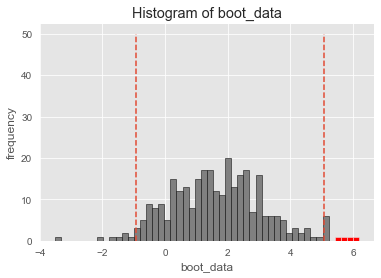

{'boot_data': [1.395,
  2.8400000000000003,
  4.484999999999999,
  2.5549999999999997,
  2.76,
  2.415,
  -0.12499999999999978,
  2.92,
  2.96,
  1.6200000000000006,
  5.79,
  1.3200000000000003,
  1.7999999999999998,
  1.5300000000000002,
  4.3149999999999995,
  1.6199999999999997,
  0.4800000000000004,
  2.54,
  0.17500000000000004,
  1.12,
  0.5450000000000002,
  0.1900000000000006,
  2.5749999999999997,
  3.915,
  1.6300000000000003,
  -0.12499999999999956,
  4.864999999999999,
  -0.6550000000000002,
  3.755,
  5.17,
  -0.95,
  0.8449999999999998,
  1.495,
  5.565,
  2.4350000000000005,
  2.3099999999999996,
  2.4849999999999994,
  -0.5799999999999992,
  1.005,
  -0.07999999999999918,
  -0.4499999999999993,
  3.369999999999999,
  0.3799999999999999,
  1.5,
  1.9799999999999998,
  3.744999999999999,
  -0.12500000000000044,
  1.044999999999999,
  1.3800000000000008,
  0.8500000000000005,
  2.5250000000000004,
  1.52,
  2.2249999999999996,
  -2.0,
  1.995,
  2.4749999999999996,
  2.91

In [130]:
get_bootstrap(
    df.query("campaign_name == 'Control Campaign'").conv_to_purchase, # числовые значения первой выборки
    df.query("campaign_name == 'Test Campaign'").conv_to_purchase, # числовые значения второй выборки
    boot_it = 300, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)